# Menu <a class="anchor" id="menu"></a>
* [1. Exploratory Data Analysis (EDA)](#eda)
* [2. Experimenting various models](#models)
    * [2.0 Preparing the dataset](#models_prepare)
    * [2.1 Establishing a baseline with DummyClassifier](#models_dummy)
    * [2.2 Logistic Regression](#models_linear)
    * [2.3 Decision Tree](#models_decision_tree)
    * [2.4 Random Forest](#models_random_forest)
    * [2.5 XGBoost](#models_xgboost)
* [3. Impoving the models with GreadSearchCV](#models_grid)
    * [3.1 Logistic Regression Grid](#models_linear_grid)
    * [3.2 Decision Tree Grid](#models_decision_tree_grid)
    * [3.3 Random Forest Grid](#models_random_forest_grid)
    * [3.4 XGBoost Grid](#models_xgboost_grid)
* [4. Impoving the models with solutions for Imbalanced datasets](#models_balanced)
    * [4.1 Balanced Logistic Regression Grid](#models_linear_balanced)
    * [4.2 Balanced Decision Tree Grid](#models_decision_tree_balanced)
    * [4.3 Balanced Random Forest Grid](#models_random_forest_balanced)
    * [4.4 Balanced XGBoost Grid](#models_xgboost_balanced)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from zipfile import ZipFile

In [2]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

# Exploratory Data Analysis (EDA) <a class="anchor" id="eda"></a> [⇪](#menu)

In [3]:
data_application_train = pd.read_csv(zip_file.open('application_train.csv'))
data_application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [4]:
data_application_train.drop(['SK_ID_CURR'], axis=1, inplace=True)

In [5]:
print(f"The shape of our application_train dataset is: {data_application_train.shape}")

The shape of our application_train dataset is: (307511, 121)


In [6]:
data_application_train.describe().T

count           mean            std      min  \
TARGET                      307511.0       0.080729       0.272419      0.0   
CNT_CHILDREN                307511.0       0.417052       0.722121      0.0   
AMT_INCOME_TOTAL            307511.0  168797.919297  237123.146279  25650.0   
AMT_CREDIT                  307511.0  599025.999706  402490.776996  45000.0   
AMT_ANNUITY                 307499.0   27108.573909   14493.737315   1615.5   
...                              ...            ...            ...      ...   
AMT_REQ_CREDIT_BUREAU_DAY   265992.0       0.007000       0.110757      0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  265992.0       0.034362       0.204685      0.0   
AMT_REQ_CREDIT_BUREAU_MON   265992.0       0.267395       0.916002      0.0   
AMT_REQ_CREDIT_BUREAU_QRT   265992.0       0.265474       0.794056      0.0   
AMT_REQ_CREDIT_BUREAU_YEAR  265992.0       1.899974       1.869295      0.0   

                                 25%       50%       75%          max  
TARGET                           0.0       0.0       0.0          1.0  
CNT_CHILDREN                     0.0       0.0       1.0         19.0  
AMT_INCOME_TOTAL            112500.0  147150.0  202500.0  117000000.0  
AMT_CREDIT                  270000.0  513531.0  808650.0    4050000.0  
AMT_ANNUITY                  16524.0   24903.0   34596.0     258025.5  
...                              ...       ...       ...          ...  
AMT_REQ_CREDIT_BUREAU_DAY        0.0       0.0       0.0          9.0  
AMT_REQ_CREDIT_BUREAU_WEEK       0.0       0.0       0.0          8.0  
AMT_REQ_CREDIT_BUREAU_MON        0.0       0.0       0.0         27.0  
AMT_REQ_CREDIT_BUREAU_QRT        0.0       0.0       0.0        261.0  
AMT_REQ_CREDIT_BUREAU_YEAR       0.0       1.0       3.0         25.0  

[105 rows x 8 columns]

In [7]:
data_application_train.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

## Let's look at the filling rate

In [8]:
# Définissons une fonction qui nous permet d'afficher 
# facilement le nombre de valeurs manquantes / présentes et leur taux

def get_fill_rate(dataset):
    return  dataset.notnull().mean(axis=0)
    
def print_fill_rate(dataset, col_array, sort_by_score=False):
    fill_ratio = get_fill_rate(dataset)*100.0
    fill_count = dataset[col_array].notnull().sum()
    
    total = dataset.shape[0]
    max_size = max([len(x) for x in dataset.columns])
    col_size = 15

    if sort_by_score:
        fill_count = fill_count.sort_values(ascending=False)    
        
    print(f"{'COLONNE'.rjust(max_size)} | {'LIGNES VIDES'.center(col_size)} | {'REMPLISSAGE'.rjust(col_size)} \n{'-'*111}")
    
    for k, v in fill_count.iteritems():
        fraction = fill_ratio[k]
        print(f"{k.rjust(max_size)} | {total-v:15} | {fraction:15.2f}%")
        
    return fill_ratio

In [9]:
fill_ratio = print_fill_rate(data_application_train, data_application_train.columns, sort_by_score=True)

                     COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
                      TARGET |               0 |          100.00%
  WEEKDAY_APPR_PROCESS_START |               0 |          100.00%
  REG_REGION_NOT_LIVE_REGION |               0 |          100.00%
 LIVE_REGION_NOT_WORK_REGION |               0 |          100.00%
      REG_CITY_NOT_LIVE_CITY |               0 |          100.00%
      REG_CITY_NOT_WORK_CITY |               0 |          100.00%
     LIVE_CITY_NOT_WORK_CITY |               0 |          100.00%
           ORGANIZATION_TYPE |               0 |          100.00%
            FLAG_DOCUMENT_21 |               0 |          100.00%
            FLAG_DOCUMENT_20 |               0 |          100.00%
            FLAG_DOCUMENT_19 |               0 |          100.00%
            FLAG_DOCUMENT_18 |               0 |          100.00%
            FLAG_DOCUMENT_17 |

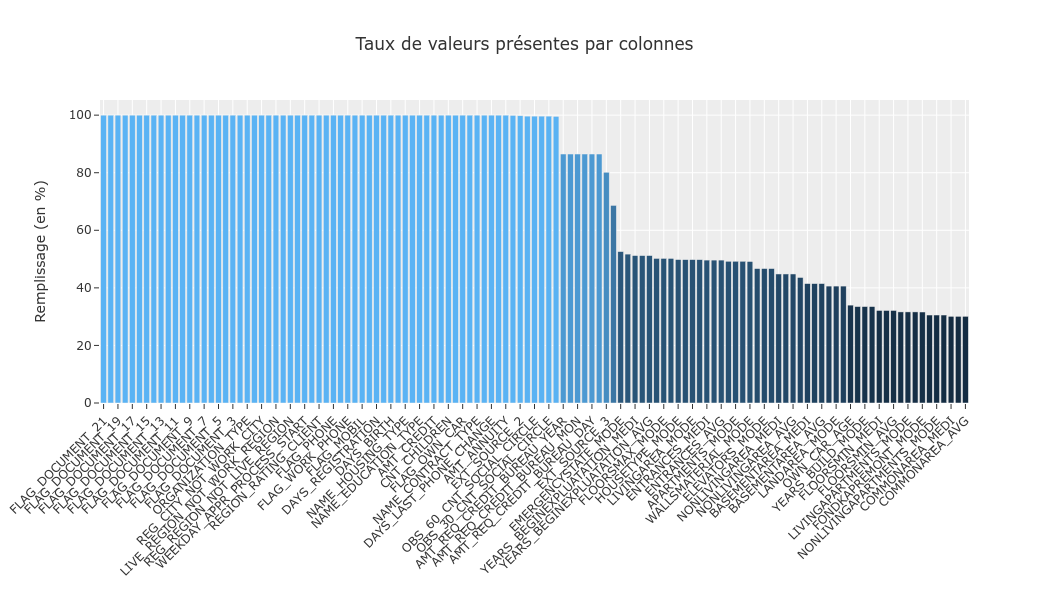

In [10]:
fill_ratio_df = pd.DataFrame(fill_ratio, columns=["fill_rate"])

fig = px.bar(fill_ratio_df, y="fill_rate", 
             width=1000,
             height=600,
             color='fill_rate', 
             title="Taux de valeurs présentes par colonnes",
             labels={
                "fill_rate": "Remplissage (en %)",
                "index": "",
                },
             template='ggplot2',
            )
fig.update_coloraxes(showscale=False)
fig.update_xaxes(tickangle = -45, categoryorder="total descending")
#fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'}) # fond transparent pour l'export
fig.show()

## Let's explore the `TARGET` variable

In [11]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm #, uniform

----- Explore 'EXT_SOURCE_3' -----
              GLOBAL       Target 0      Target 1
count  246546.000000  227398.000000  19148.000000
mean        0.510853       0.520969      0.390717
std         0.194844       0.190465      0.205810
min         0.000527       0.000527      0.000527
25%         0.370650       0.385915      0.223831
50%         0.535276       0.546023      0.379100
75%         0.669057       0.673830      0.553165
max         0.896010       0.893976      0.896010


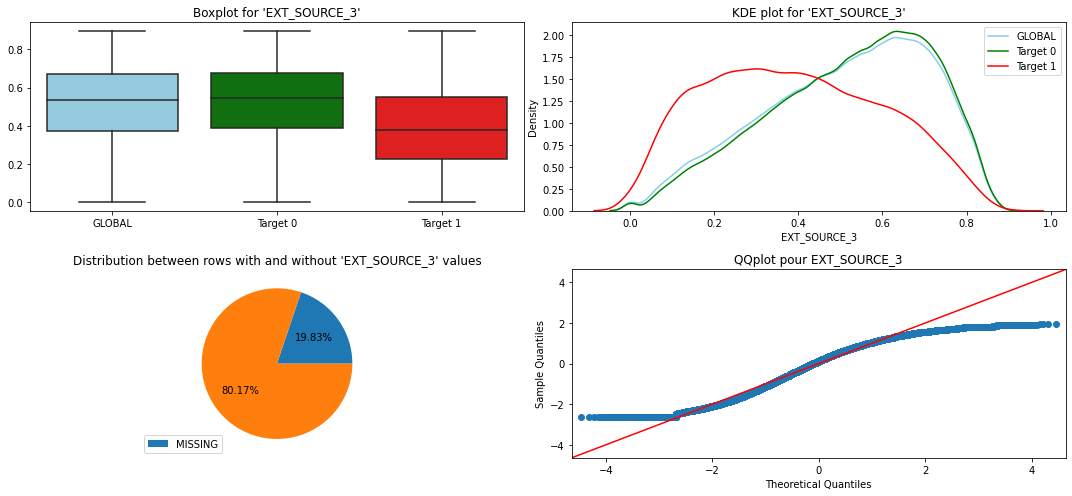

'EXT_SOURCE_3' is missing 60965 over 307511 (19.83%)


In [12]:
def explore_quantitative(data, col_name):
    
    fig = plt.figure(figsize =(15, 7))
    
    dt = data[col_name]
    dt0 = data[data.TARGET == 0][col_name]
    dt1 = data[data.TARGET == 1][col_name]
    
    # Describe 
    print(f"----- Explore '{col_name}' -----")
    mdf = pd.DataFrame({"GLOBAL":dt, "Target 0":dt0, "Target 1":dt1})
    print(mdf.describe())
    
    # Box plot with each target value
    ax = plt.subplot(2, 2, 1)
    my_colors = {"GLOBAL": "skyblue", "Target 0": "green", "Target 1":"red"}
    sns.boxplot(data=mdf, palette=my_colors) 
    plt.title(f"Boxplot for '{col_name}'")
    
    # KDE plot with each target value
    ax = plt.subplot(2, 2, 2)
    sns.kdeplot(dt, color='skyblue', shade=False)
    sns.kdeplot(dt0, color='green')
    sns.kdeplot(dt1, color='red')
    plt.title(f"KDE plot for '{col_name}'")
    plt.legend(["GLOBAL", "Target 0", "Target 1"])
    
    # QQ plot for normality
    ax = plt.subplot(2, 2, 4)
    ax.set_title(f"QQplot pour {col_name}")
    qqplot(dt[dt.notnull()], norm, fit=True, line="45", ax=ax)
    
    # Missing
    total_size = dt.shape[0]
    total_size_nonull = dt.notnull().sum()
    total_size_null = dt.isnull().sum()
    percent_v = 100/total_size*total_size_null
     
    ax = plt.subplot(2, 2, 3)
    plt.pie(list([total_size_null,total_size_nonull]), 
        labels=["", ""],
        autopct=lambda x: f"{x:.2f}%", shadow=False)
    plt.title(f"Distribution between rows with and without '{col_name}' values")
    plt.legend(["MISSING"], loc='lower center', bbox_to_anchor=(0, 0))
    
    # Scatter (multivariate)
    #ax = plt.subplot(3, 2, 5)
    #sns.scatterplot(data=data[data.TARGET == 0], x=col_name, y='TARGET', color='blue')
    #sns.scatterplot(data=data[data.TARGET == 1], x=col_name, y='TARGET', color='red')
    
    fig.tight_layout()
    plt.show()
    
    print(f"'{col_name}' is missing {total_size_null} over {total_size} ({percent_v:.2f}%)")
    
explore_quantitative(data_application_train, 'EXT_SOURCE_3')

In [13]:
corr_target = data_application_train.corr()['TARGET'].sort_values(ascending=False)

In [14]:
view_size = 100
seuil = 0.05
print(f"{f'TOP POSITIVES > {seuil}'.rjust(40)}          {f'TOP NEGATIVES < -{seuil}'.rjust(40)}\n{'-'*100}")
for row in zip(
    corr_target.head(view_size).index, corr_target.head(view_size), 
    reversed(corr_target.tail(view_size).index), reversed(corr_target.tail(view_size))):
    print(f"{row[0].rjust(40)} : {row[1]:6.4f} {row[2].rjust(40)} : {row[3]:6.4f}")
    if(row[1] < seuil and row[3] > -seuil):
        break

                    TOP POSITIVES > 0.05                             TOP NEGATIVES < -0.05
----------------------------------------------------------------------------------------------------
                                  TARGET : 1.0000                             EXT_SOURCE_3 : -0.1789
                              DAYS_BIRTH : 0.0782                             EXT_SOURCE_2 : -0.1605
             REGION_RATING_CLIENT_W_CITY : 0.0609                             EXT_SOURCE_1 : -0.1553
                    REGION_RATING_CLIENT : 0.0589                            DAYS_EMPLOYED : -0.0449
                  DAYS_LAST_PHONE_CHANGE : 0.0552                            FLOORSMAX_AVG : -0.0440
                         DAYS_ID_PUBLISH : 0.0515                           FLOORSMAX_MEDI : -0.0438
                  REG_CITY_NOT_WORK_CITY : 0.0510                           FLOORSMAX_MODE : -0.0432
                          FLAG_EMP_PHONE : 0.0460                          AMT_GOODS_PRICE : -0.0396


## Feature Engigeering

In [15]:
data_clean = data_application_train[:30000].copy()

In [16]:
import missingno as msno

# Experimenting various models <a class="anchor" id="models"></a> [⇪](#menu)

## 0. Preparing the dataset <a class="anchor" id="models_prepare"></a> [⇪](#menu)

### Splitting the dataset between `train`, `validation` and `test` sets

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X_full = data_clean.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_clean['TARGET']

In [64]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.20,
                                                random_state=0)

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(
                                                X_train_full, 
                                                y_train_full, 
                                                test_size=X_test.shape[0], 
                                                random_state=0)

In [66]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((18000, 120), (18000,), (6000, 120), (6000,), (6000, 120), (6000,))

### Encoding the qualitative variables

In [67]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [68]:
oe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() == 2]
ohe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() > 2]

In [69]:
def fit_labels(data):
    """ Prepare the encoder for the ordinal columns.
    - Columns with 2 unique values are encoded using an OrdinalEncoder
    - Columns with more than 2 unique values are encoded using a OneHotEncoder
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    oe_targets = []
    ohe_targets = []
    
    for col in data.select_dtypes(exclude='number').columns:
        if data[col].nunique() == 2:
            oe_targets.append(col)
        else:
            ohe_targets.append(col)
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_mode):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

#### Fit the encoders

In [70]:
oe_model, ohe_model = fit_labels(X_train)

#### Transform the `training`, `validation` and `testing` sets

In [71]:
X_train = transform_labels(X_train, oe_model, ohe_model)
X_valid = transform_labels(X_valid, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations

In [72]:
from sklearn.impute import SimpleImputer

In [73]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    print(dt.shape, type(dt))
    
    return dt

In [74]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [75]:
X_train = impute(X_train, imputer_model)
X_test = impute(X_test, imputer_model)
# We do not transform validation and test sets

(18000, 241) <class 'pandas.core.frame.DataFrame'>
(6000, 241) <class 'pandas.core.frame.DataFrame'>


<AxesSubplot:>

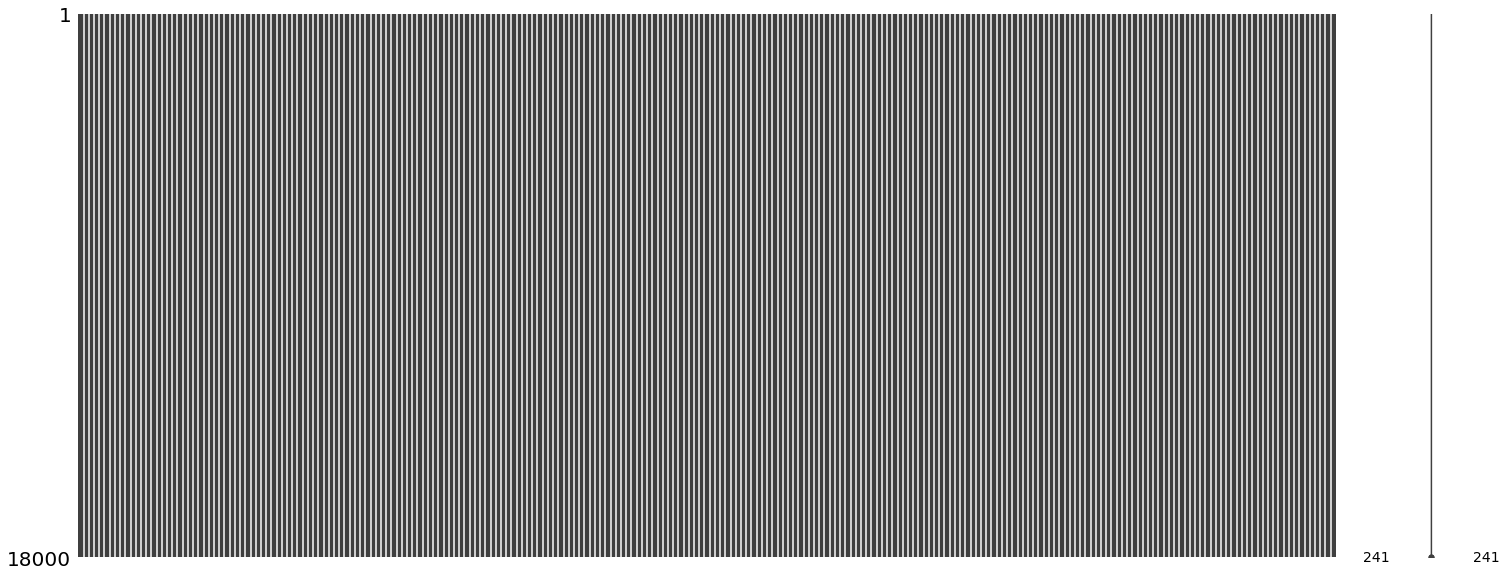

In [76]:
msno.matrix(X_train)

### Normalizing the dataset

In [77]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [78]:
def fit_normalizer(data):
    
    #minmax_scaler = MinMaxScaler(feature_range = (0, 1))
    #minmax_scaler.fit(data)
    
    #std_scaler = StandardScaler()
    #std_scaler.fit(data)
    
    #return minmax_scaler, std_scaler
    
    robust_scaler = RobustScaler()
    robust_scaler.fit(data)
    
    return robust_scaler

#def normalize(data, minmax_scaler, std_scaler):
def normalize(data, robust_scaler):
    
    dt = data.copy()
    #dt = pd.DataFrame(minmax_scaler.transform(dt), index=dt.index, columns=dt.columns)
    #dt = pd.DataFrame(std_scaler.transform(dt), index=dt.index, columns=dt.columns)
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [79]:
#normalizer_model, standardizer_model = fit_normalizer(X_train)
model_scaler = fit_normalizer(X_train)

In [80]:
#X_train = normalize(X_train, normalizer_model, standardizer_model)
#X_valid = normalize(X_valid, normalizer_model, standardizer_model)
#X_test = normalize(X_test, normalizer_model, standardizer_model)

X_train = normalize(X_train, model_scaler)
X_valid = normalize(X_valid, model_scaler)
X_test = normalize(X_test, model_scaler)

### Define some report functions

In [36]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score

In [37]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---\n\n", report)

In [38]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---\n")
    plt.show()

In [39]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None):
    
    print(f"--- ROC AUC ---\n")
    auc_scores = {}
    last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt

    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        alpha_v = 1 if i == last_index-1 else 0.5
        
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    plt.legend()
    
    return auc_scores

In [40]:
scores = pd.DataFrame(columns=['Method', 'ROC AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN'])
y_preds = {}
scores_path = 'data/scores.csv'
scores.to_csv(scores_path, index=False)

def get_scores(method_name, y_true, y_pred, y_pred_proba, register=False, simple=False):
    
    rocauc_value = roc_auc_score(y_true, y_pred_proba)
    f1_value = f1_score(y_true, y_pred)
    accuracy_value = accuracy_score(y_true, y_pred)
    precision_value = precision_score(y_true, y_pred, zero_division=0)
    recall_value = recall_score(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    
    # Register score and replace if it already exists
    if register:
        idx = np.where(scores.Method == method_name)[0]        
        idx = idx[0] if idx.size > 0 else len(scores.index)
        scores.loc[idx] = [method_name, rocauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN]
        
        scores.to_csv(scores_path, index=False)
    
    # Basic report
    print(f"--- {method_name} ---\n\nROC AUC:{rocauc_value}\nF1-score:{f1_value}\nRecall:{recall_value}\n")
    
    if simple:
        return
    
    # Classification report
    print_classification_report(y_true, y_pred)
    
    # Confusion Matrix
    print_confusion_matrix(y_true, y_pred)
    
    # ROC AUC curves
    y_preds[method_name] = y_pred_proba
    print_rocauc(y_true, y_preds)

## 1. Establishing baseline with Dummy Classifier <a class="anchor" id="models_dummy"></a> [⇪](#menu)

In [41]:
from sklearn.dummy import DummyClassifier

In [42]:
clf_dummy = DummyClassifier(strategy='stratified', random_state=0)
clf_dummy.fit(X_train, y_train)

DummyClassifier(random_state=0, strategy='stratified')

--- Dummy ---

ROC AUC:0.49360547881959144
F1-score:0.06860706860706861
Recall:0.07021276595744681

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.92      0.92      5530
Prediction = 1       0.07      0.07      0.07       470

      accuracy                           0.85      6000
     macro avg       0.49      0.49      0.49      6000
  weighted avg       0.85      0.85      0.85      6000

--- Confusion Matrix ---



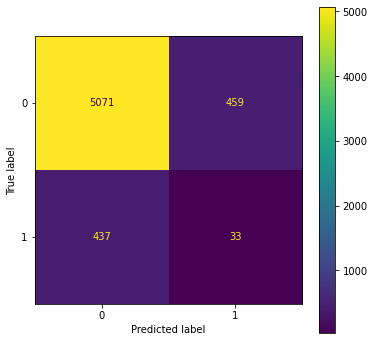

--- ROC AUC ---



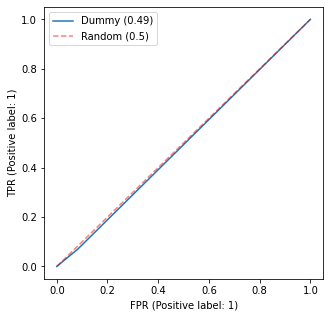

In [43]:
y_pred_dummy = clf_dummy.predict(X_test)
y_pred_proba_dummy = clf_dummy.predict_proba(X_test)[:,1]

get_scores("Dummy", y_test, y_pred_dummy, y_pred_proba_dummy, register=True)

> - The **recall** means "how many of this class you find over the whole number of element of this class"
> - The **precision** will be "how many are correctly classified among that class"
> - The **f1-score** is the harmonic mean between precision & recall
> - The **support** is the number of occurence of the given class in your dataset


## 2. Logistic Regression <a class="anchor" id="models_linear"></a> [⇪](#menu)

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
clf_log = LogisticRegression(C=0.1, random_state=0)
clf_log.fit(X_train, y_train)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=0.1, random_state=0)

--- Basic RegLog ---

ROC AUC:0.7227397945442653
F1-score:0.01680672268907563
Recall:0.00851063829787234

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5530
Prediction = 1       0.67      0.01      0.02       470

      accuracy                           0.92      6000
     macro avg       0.79      0.50      0.49      6000
  weighted avg       0.90      0.92      0.89      6000

--- Confusion Matrix ---



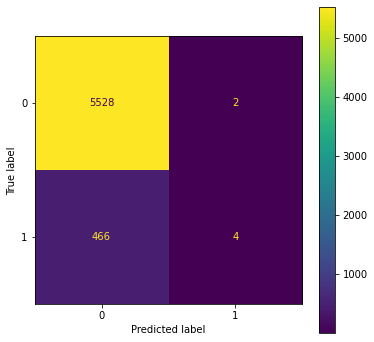

--- ROC AUC ---



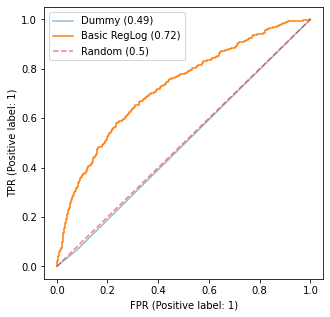

In [46]:
y_pred_log = clf_log.predict(X_test)
y_pred_proba_log = clf_log.predict_proba(X_test)[:,1]

get_scores("Basic RegLog", y_test, y_pred_log, y_pred_proba_log, register=True)

## 3. Decision Tree <a class="anchor" id="models_decision_tree"></a> [⇪](#menu)

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

--- Basic Decision Tree ---

ROC AUC:0.5435150629063906
F1-score:0.1584158415841584
Recall:0.1702127659574468

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.92      0.92      5530
Prediction = 1       0.15      0.17      0.16       470

      accuracy                           0.86      6000
     macro avg       0.54      0.54      0.54      6000
  weighted avg       0.87      0.86      0.86      6000

--- Confusion Matrix ---



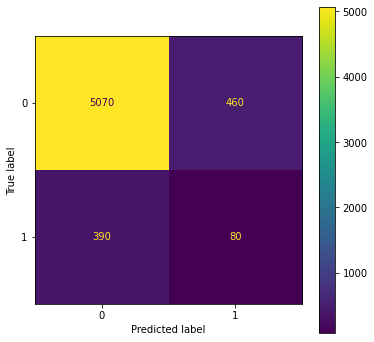

--- ROC AUC ---



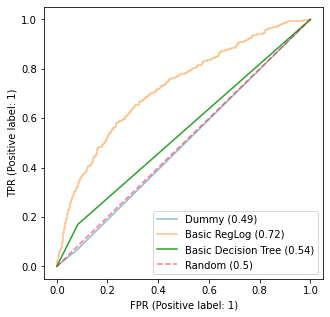

In [49]:
y_pred_dt = clf_dt.predict(X_test)
y_pred_proba_dt = clf_dt.predict_proba(X_test)[:,1]

get_scores("Basic Decision Tree", y_test, y_pred_dt, y_pred_proba_dt, register=True)

## 4. Random Forest <a class="anchor" id="models_random_forest"></a> [⇪](#menu)

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

--- Basic Random Forest ---

ROC AUC:0.6823781308914624
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5530
Prediction = 1       0.00      0.00      0.00       470

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



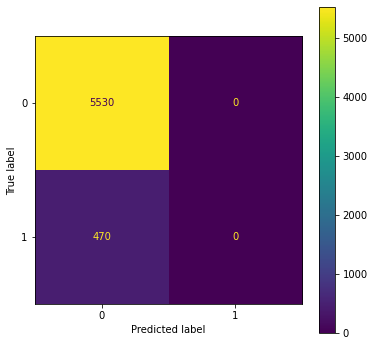

--- ROC AUC ---



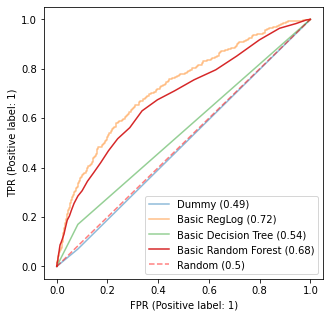

In [52]:
y_pred_rf = clf_rf.predict(X_test)
y_pred_proba_rf = clf_rf.predict_proba(X_test)[:,1]

get_scores("Basic Random Forest", y_test, y_pred_rf, y_pred_proba_rf, register=True)

## 5. XGBoost Classifier <a class="anchor" id="models_xgboost"></a> [⇪](#menu)

In [53]:
from xgboost import XGBClassifier

In [54]:
clf_xgb = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1
)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

--- Basic XGBoost ---

ROC AUC:0.7178457927744218
F1-score:0.08646616541353384
Recall:0.04893617021276596

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      5530
Prediction = 1       0.37      0.05      0.09       470

      accuracy                           0.92      6000
     macro avg       0.65      0.52      0.52      6000
  weighted avg       0.88      0.92      0.89      6000

--- Confusion Matrix ---



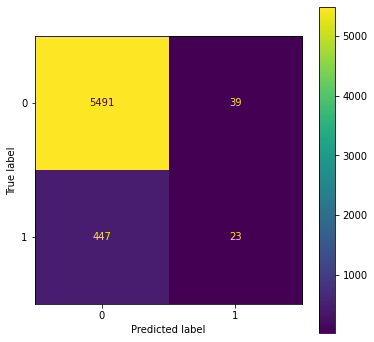

--- ROC AUC ---



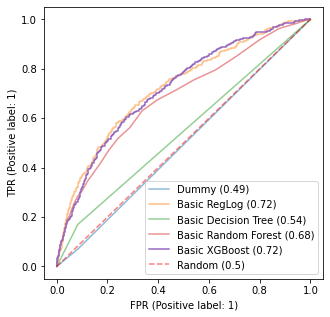

In [55]:
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_proba_xgb = clf_xgb.predict_proba(X_test)[:,1]

get_scores("Basic XGBoost", y_test, y_pred_xgb, y_pred_proba_xgb, register=True)

## 6. Review scores <a class="anchor" id="models_scores"></a> [⇪](#menu)

In [56]:
scores

Method   ROC AUC  F1 score  Accuracy  Precision    Recall  TP  \
0                Dummy  0.493605  0.068607  0.850667   0.067073  0.070213  33   
1         Basic RegLog  0.722740  0.016807  0.922000   0.666667  0.008511   4   
2  Basic Decision Tree  0.543515  0.158416  0.858333   0.148148  0.170213  80   
3  Basic Random Forest  0.682378  0.000000  0.921667   0.000000  0.000000   0   
4        Basic XGBoost  0.717846  0.086466  0.919000   0.370968  0.048936  23   

     TN   FP   FN  
0  5071  459  437  
1  5528    2  466  
2  5070  460  390  
3  5530    0  470  
4  5491   39  447

In [57]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']]

Method   ROC AUC  F1 score    Recall
0                Dummy  0.493605  0.068607  0.070213
1         Basic RegLog  0.722740  0.016807  0.008511
2  Basic Decision Tree  0.543515  0.158416  0.170213
3  Basic Random Forest  0.682378  0.000000  0.000000
4        Basic XGBoost  0.717846  0.086466  0.048936

# Improving the models with GridSearchCV <a class="anchor" id="models_grid"></a> [⇪](#menu)

In [59]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

In [81]:
X_train_full = transform_labels(X_train_full, oe_model, ohe_model)
X_train_full = impute(X_train_full, imputer_model)
X_train_full = normalize(X_train_full, model_scaler)

num_samples = 10000
X_train_full = X_train_full[:num_samples]
y_train_full = y_train_full[:num_samples]

(24000, 241) <class 'pandas.core.frame.DataFrame'>


In [85]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

## 1. Logistic Regression Grid<a class="anchor" id="models_linear_grid"></a> [⇪](#menu)

In [60]:
param_grid = [
    {
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['saga'],
        'penalty' : ['l1', 'l2', 'elasticnet'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]


In [61]:
clf_log_model = LogisticRegression(max_iter=1000, random_state=0)

In [62]:
clf_log_grid = GridSearchCV(clf_log_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
clf_log_grid.fit(X_train_full, y_train_full)
#clf_log_grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)



GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=LogisticRegression(max_iter=1000, random_state=0),
             n_jobs=-1,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['saga']}],
             scoring='roc_auc', verbose=1)

In [63]:
clf_log_grid.best_params_

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

In [64]:
y_pred_log_grid = clf_log_grid.predict(X_test)
y_pred_proba_log_grid = clf_log_grid.predict_proba(X_test)[:,1]
get_scores("Grid LogReg", y_test, y_pred_log_grid, y_pred_proba_log_grid, register=False, simple=True)

--- Grid LogReg ---

ROC AUC:0.7098491785618097
F1-score:0.0
Recall:0.0



#### We train a new model using the best parameters

In [65]:
clf_log2 = LogisticRegression( **clf_log_grid.best_params_, random_state=0, max_iter=1000 )
clf_log2.fit(X_train_full, y_train_full)
#clf_log2.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=0,
                   solver='liblinear')

--- Grid LogReg ---

ROC AUC:0.7098491785618097
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5530
Prediction = 1       0.00      0.00      0.00       470

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



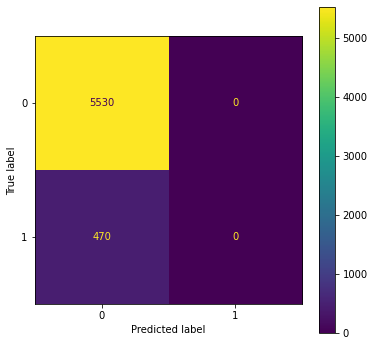

--- ROC AUC ---



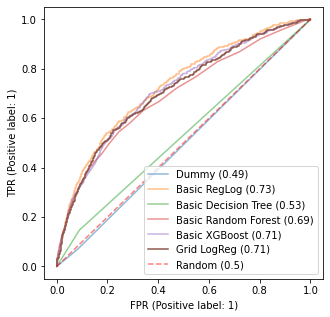

In [66]:
y_pred_log_grid = clf_log2.predict(X_test)
y_pred_proba_log_grid = clf_log2.predict_proba(X_test)[:,1]

get_scores("Grid LogReg", y_test, y_pred_log_grid, y_pred_proba_log_grid, register=True)

## 2. Decision Tree Grid <a class="anchor" id="models_decision_tree_grid"></a> [⇪](#menu)

In [86]:
param_grid = {
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
    'criterion' :['gini', 'entropy']
}

In [87]:
clf_dt_model = DecisionTreeClassifier(random_state=0)

In [88]:
clf_dt_grid = GridSearchCV(clf_dt_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
clf_dt_grid.fit(X_train_full, y_train_full)
#clf_dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [None, 'auto', 'sqrt', 'log2']},
             scoring='roc_auc', verbose=1)

In [89]:
clf_dt_grid.best_params_

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None}

In [90]:
y_pred_dt_grid = clf_dt_grid.predict(X_test)
y_pred_proba_dt_grid = clf_dt_grid.predict_proba(X_test)[:,1]

get_scores("Grid Decision Tree", y_test, y_pred_dt_grid, y_pred_proba_dt_grid, register=False, simple=True)

--- Grid Decision Tree ---

ROC AUC:0.6673652418144742
F1-score:0.004228329809725159
Recall:0.002127659574468085



#### We train a new model using the best parameters

In [91]:
clf_dt2 = DecisionTreeClassifier( **clf_dt_grid.best_params_, random_state=0 )
clf_dt2.fit(X_train_full, y_train_full)
#clf_dt2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=5,
                       random_state=0)

--- Grid Decision Tree ---

ROC AUC:0.6673652418144742
F1-score:0.004228329809725159
Recall:0.002127659574468085

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5530
Prediction = 1       0.33      0.00      0.00       470

      accuracy                           0.92      6000
     macro avg       0.63      0.50      0.48      6000
  weighted avg       0.88      0.92      0.88      6000

--- Confusion Matrix ---



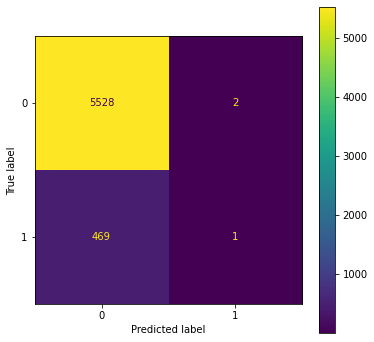

--- ROC AUC ---



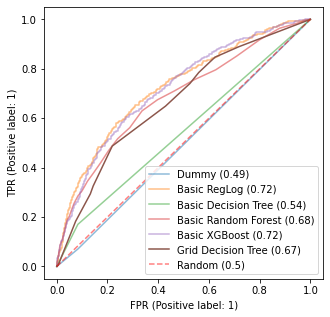

In [92]:
y_pred_dt_grid = clf_dt2.predict(X_test)
y_pred_proba_dt_grid = clf_dt2.predict_proba(X_test)[:,1]

get_scores("Grid Decision Tree", y_test, y_pred_dt_grid, y_pred_proba_dt_grid, register=True)

## 3. Random Forest Grid <a class="anchor" id="models_random_forest_grid"></a> [⇪](#menu)

In [100]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    'n_estimators' :[64, 100, 128, 256, 528]
}

In [101]:
clf_rf_model = RandomForestClassifier(random_state=0)

In [ ]:
clf_rf_grid = GridSearchCV(clf_rf_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
clf_rf_grid.fit(X_train_full, y_train_full)
#clf_rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [ ]:
clf_rf_grid.best_params_

In [ ]:
y_pred_rf_grid = clf_rf_grid.predict(X_test)
y_pred_proba_rf_grid = clf_rf_grid.predict_proba(X_test)[:,1]
get_scores("Grid Random Forest", y_test, y_pred_rf_grid, y_pred_proba_rf_grid, register=False, simple=True)

#### We train a new model using the best parameters

In [ ]:
clf_rf2 = RandomForestClassifier( **clf_rf_grid.best_params_, random_state=0 )
clf_rf2.fit(X_train_full, y_train_full)
#clf_rf2.fit(X_train, y_train)

In [ ]:
y_pred_rf_grid = clf_rf2.predict(X_test)
y_pred_proba_rf_grid = clf_rf2.predict_proba(X_test)[:,1]

get_scores("Grid Random Forest", y_test, y_pred_rf_grid, y_pred_proba_rf_grid, register=True)

## 4. XGBoost Classifier Grid<a class="anchor" id="models_xgboost_grid"></a> [⇪](#menu)

In [81]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [82]:
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [83]:
clf_xgb_model = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1
)

In [84]:
clf_xgb_grid = RandomizedSearchCV(clf_xgb_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
clf_xgb_grid.fit(X_train_full, y_train_full)
#clf_xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
      

In [85]:
clf_xgb_grid.best_params_

{'n_estimators': 180, 'max_depth': 2, 'learning_rate': 0.05}

In [86]:
y_pred_xgb_grid = clf_xgb_grid.predict(X_test)
y_pred_proba_xgb_grid = clf_xgb_grid.predict_proba(X_test)[:,1]

get_scores("Grid GXBoost", y_test, y_pred_xgb_grid, y_pred_proba_xgb_grid, register=False, simple=True)

--- Grid GXBoost ---

ROC AUC:0.7134852448924627
F1-score:0.0
Recall:0.0



#### We train a new model using the best parameters

In [87]:
clf_xgb2 = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1,
    **clf_xgb_grid.best_params_, 
)

clf_xgb2.fit(X_train_full, y_train_full)
#clf_xgb2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=180,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

--- Grid XGBoost ---

ROC AUC:0.7134852448924627
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5530
Prediction = 1       0.00      0.00      0.00       470

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



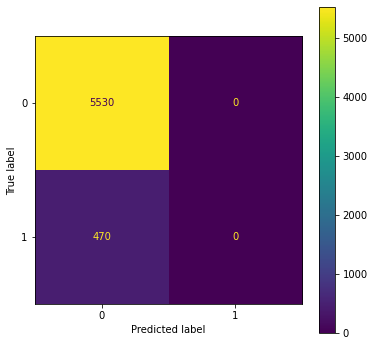

--- ROC AUC ---



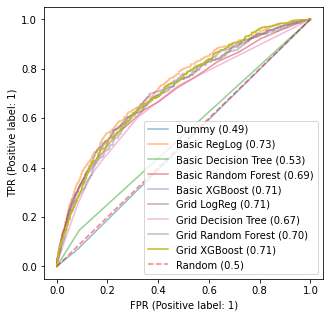

In [88]:
y_pred_xgb_grid = clf_xgb2.predict(X_test)
y_pred_proba_xgb_grid = clf_xgb2.predict_proba(X_test)[:,1]

get_scores("Grid XGBoost", y_test, y_pred_xgb_grid, y_pred_proba_xgb_grid, register=True)

## 5. Review scores <a class="anchor" id="models_grid_scores"></a> [⇪](#menu)

In [89]:
scores

Method   ROC AUC  F1 score  Accuracy  Precision    Recall  TP  \
0                Dummy  0.493605  0.068607  0.850667   0.067073  0.070213  33   
1         Basic RegLog  0.730337  0.008421  0.921500   0.400000  0.004255   2   
2  Basic Decision Tree  0.528920  0.133851  0.851167   0.122995  0.146809  69   
3  Basic Random Forest  0.693624  0.000000  0.921667   0.000000  0.000000   0   
4        Basic XGBoost  0.714666  0.076190  0.919167   0.363636  0.042553  20   
5          Grid LogReg  0.709849  0.000000  0.921667   0.000000  0.000000   0   
6   Grid Decision Tree  0.674888  0.020833  0.921667   0.500000  0.010638   5   
7   Grid Random Forest  0.699274  0.000000  0.921667   0.000000  0.000000   0   
8         Grid XGBoost  0.713485  0.000000  0.921667   0.000000  0.000000   0   

     TN   FP   FN  
0  5071  459  437  
1  5527    3  468  
2  5038  492  401  
3  5530    0  470  
4  5495   35  450  
5  5530    0  470  
6  5525    5  465  
7  5530    0  470  
8  5530    0  470

In [91]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('Recall', ascending=False)

Method   ROC AUC  F1 score    Recall
2  Basic Decision Tree  0.528920  0.133851  0.146809
0                Dummy  0.493605  0.068607  0.070213
4        Basic XGBoost  0.714666  0.076190  0.042553
6   Grid Decision Tree  0.674888  0.020833  0.010638
1         Basic RegLog  0.730337  0.008421  0.004255
3  Basic Random Forest  0.693624  0.000000  0.000000
5          Grid LogReg  0.709849  0.000000  0.000000
7   Grid Random Forest  0.699274  0.000000  0.000000
8         Grid XGBoost  0.713485  0.000000  0.000000

# Impoving the models with solutions for Imbalanced datasets <a class="anchor" id="models_balanced"></a> [⇪](#menu)

## 1. Balanced Logistic Regression Grid<a class="anchor" id="models_linear_balanced"></a> [⇪](#menu)

In [92]:
param_grid = [
    {
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['saga'],
        'penalty' : ['l1', 'l2', 'elasticnet'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [93]:
clf_log_model_imb = LogisticRegression(max_iter=1000, random_state=0, class_weight='balanced')

In [94]:
clf_log_imb = GridSearchCV(clf_log_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
clf_log_imb.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)



GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=0),
             n_jobs=-1,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['saga']}],
             scoring='roc_auc', verbose=1)

In [95]:
clf_log_imb.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [96]:
y_pred_log_imb = clf_log_imb.predict(X_test)
y_pred_proba_log_imb = clf_log_imb.predict_proba(X_test)[:,1]
get_scores("Balanced LogReg", y_test, y_pred_log_imb, y_pred_proba_log_imb, register=False, simple=True)

--- Balanced LogReg ---

ROC AUC:0.730541341233504
F1-score:0.10450450450450452
Recall:0.06170212765957447



#### We train a new model using the best parameters

In [97]:
clf_log_imb2 = LogisticRegression( **clf_log_imb.best_params_, max_iter=1000, random_state=0, class_weight='balanced')

--- Balanced LogReg ---

ROC AUC:0.730541341233504
F1-score:0.10450450450450452
Recall:0.06170212765957447

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.99      0.96      5530
Prediction = 1       0.34      0.06      0.10       470

      accuracy                           0.92      6000
     macro avg       0.63      0.53      0.53      6000
  weighted avg       0.88      0.92      0.89      6000

--- Confusion Matrix ---



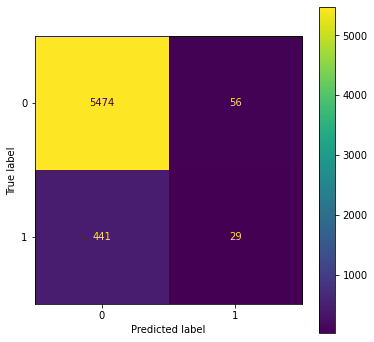

--- ROC AUC ---



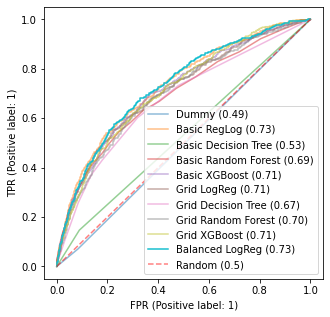

In [98]:
clf_log_imb2.fit(X_train_full, y_train_full)
y_pred_log_imb = clf_log_imb2.predict(X_test)
y_pred_proba_log_imb = clf_log_imb2.predict_proba(X_test)[:,1]

get_scores("Balanced LogReg", y_test, y_pred_log_imb, y_pred_proba_log_imb, register=True)

## 2. Balanced Decision Tree Grid <a class="anchor" id="models_decision_tree_balanced"></a> [⇪](#menu)

In [93]:
param_grid = {
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
    'criterion' :['gini', 'entropy']
}

In [94]:
clf_dt_model_imb = DecisionTreeClassifier(random_state=0, class_weight='balanced')

In [95]:
clf_dt_imb = GridSearchCV(clf_dt_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
clf_dt_imb.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [None, 'auto', 'sqrt', 'log2']},
             scoring='roc_auc', verbose=1)

In [96]:
clf_dt_imb.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None}

In [97]:
y_pred_dt_imb = clf_dt_imb.predict(X_test)
y_pred_proba_dt_imb = clf_dt_imb.predict_proba(X_test)[:,1]

get_scores("Balanced Decision Tree", y_test, y_pred_dt_imb, y_pred_proba_dt_imb, register=False, simple=True)

--- Balanced Decision Tree ---

ROC AUC:0.6694534646608441
F1-score:0.2379182156133829
Recall:0.5446808510638298



#### We train a new model using the best parameters

In [98]:
clf_dt_imb2 = DecisionTreeClassifier( **clf_dt_imb.best_params_, random_state=0, class_weight='balanced' )

--- Balanced Decision Tree ---

ROC AUC:0.6694534646608441
F1-score:0.2379182156133829
Recall:0.5446808510638298

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.74      0.83      5530
Prediction = 1       0.15      0.54      0.24       470

      accuracy                           0.73      6000
     macro avg       0.55      0.64      0.54      6000
  weighted avg       0.89      0.73      0.79      6000

--- Confusion Matrix ---



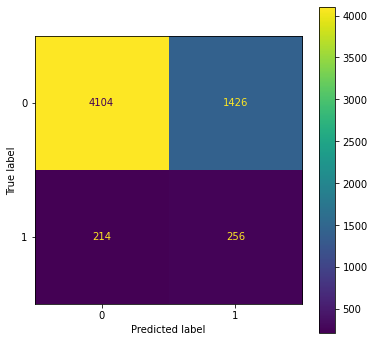

--- ROC AUC ---



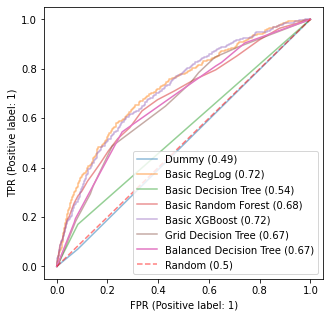

In [99]:
clf_dt_imb2.fit(X_train_full, y_train_full)
y_pred_dt_imb = clf_dt_imb2.predict(X_test)
y_pred_proba_dt_imb = clf_dt_imb2.predict_proba(X_test)[:,1]

get_scores("Balanced Decision Tree", y_test, y_pred_dt_imb, y_pred_proba_dt_imb, register=True)

## 3. Balanced Random Forest Grid <a class="anchor" id="models_random_forest_balanced"></a> [⇪](#menu)

In [ ]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    'n_estimators' :[64, 100, 128, 256, 528]
}

In [ ]:
clf_rf_model_imb = RandomForestClassifier(random_state=0, class_weight='balanced')

In [ ]:
clf_rf_imb = GridSearchCV(clf_rf_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
clf_rf_imb.fit(X_train_full, y_train_full)

In [ ]:
clf_rf_imb.best_params_

In [ ]:
y_pred_rf_imb = clf_rf_imb.predict(X_test)
y_pred_proba_rf_imb = clf_rf_imb.predict_proba(X_test)[:,1]
get_scores("Balanced Random Forest", y_test, y_pred_rf_imb, y_pred_proba_rf_imb, register=False, simple=True)

#### We train a new model using the best parameters

In [ ]:
clf_rf_imb2 = RandomForestClassifier( **clf_rf_imb.best_params_, random_state=0, class_weight='balanced')

In [ ]:
clf_rf_imb2.fit(X_train_full, y_train_full)
y_pred_rf_imb = clf_rf_imb2.predict(X_test)
y_pred_proba_rf_imb = clf_rf_imb2.predict_proba(X_test)[:,1]

get_scores("Balanced Random Forest", y_test, y_pred_rf_imb, y_pred_proba_rf_imb, register=True)

## 4. Balanced XGBoost Classifier Grid<a class="anchor" id="models_xgboost_balanced"></a> [⇪](#menu)

In [113]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [114]:
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [115]:
from collections import Counter

In [116]:
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]
scale_weigth

11.430939226519337

In [117]:
clf_xgb_model_imb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    nthread=8,
    seed=0,
    verbosity=1,
    scale_pos_weight=scale_weigth
)

In [118]:
clf_xgb_imb = RandomizedSearchCV(clf_xgb_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
clf_xgb_imb.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
      

In [119]:
clf_xgb_imb.best_params_

{'n_estimators': 180, 'max_depth': 2, 'learning_rate': 0.1}

In [120]:
y_pred_xgb_imb = clf_xgb_imb.predict(X_test)
y_pred_proba_xgb_imb = clf_xgb_imb.predict_proba(X_test)[:,1]

get_scores("Balanced XGBoost", y_test, y_pred_xgb_imb, y_pred_proba_xgb_imb, register=False, simple=True)

--- Balanced XGBoost ---

ROC AUC:0.7182538186295256
F1-score:0.13553719008264462
Recall:0.08723404255319149



#### We train a new model using the best parameters

In [121]:
clf_xgb_imb2 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    nthread=-1,
    seed=0,
    verbosity=1,
    **clf_xgb_grid.best_params_, 
    random_state=0,
    scale_pos_weight=scale_weigth
)
clf_xgb_imb2.fit(X_train_full, y_train_full)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=180,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

--- Balanced XGBoost ---

ROC AUC:0.6992495479204339
F1-score:0.2519954389965793
Recall:0.4702127659574468

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.81      0.87      5530
Prediction = 1       0.17      0.47      0.25       470

      accuracy                           0.78      6000
     macro avg       0.56      0.64      0.56      6000
  weighted avg       0.89      0.78      0.82      6000

--- Confusion Matrix ---



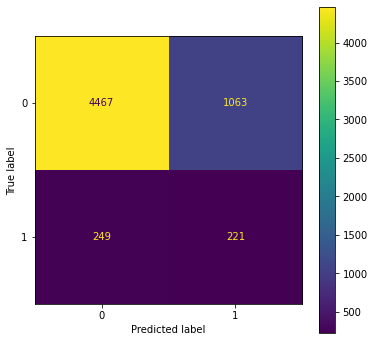

--- ROC AUC ---



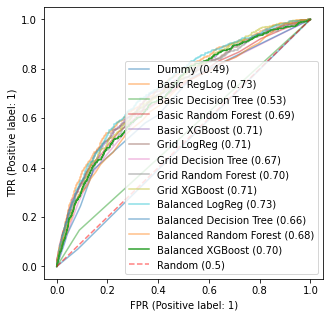

In [122]:
y_pred_xgb_imb = clf_xgb_imb2.predict(X_test)
y_pred_proba_xgb_imb = clf_xgb_imb2.predict_proba(X_test)[:,1]

get_scores("Balanced XGBoost", y_test, y_pred_xgb_imb, y_pred_proba_xgb_imb, register=True)

## 5. Review scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [123]:
scores

Method   ROC AUC  F1 score  Accuracy  Precision    Recall  \
0                    Dummy  0.493605  0.068607  0.850667   0.067073  0.070213   
1             Basic RegLog  0.730337  0.008421  0.921500   0.400000  0.004255   
2      Basic Decision Tree  0.528920  0.133851  0.851167   0.122995  0.146809   
3      Basic Random Forest  0.693624  0.000000  0.921667   0.000000  0.000000   
4            Basic XGBoost  0.714666  0.076190  0.919167   0.363636  0.042553   
5              Grid LogReg  0.709849  0.000000  0.921667   0.000000  0.000000   
6       Grid Decision Tree  0.674888  0.020833  0.921667   0.500000  0.010638   
7       Grid Random Forest  0.699274  0.000000  0.921667   0.000000  0.000000   
8             Grid XGBoost  0.713485  0.000000  0.921667   0.000000  0.000000   
9          Balanced LogReg  0.730541  0.104505  0.917167   0.341176  0.061702   
10  Balanced Decision Tree  0.662318  0.252921  0.818833   0.186802  0.391489   
11  Balanced Random Forest  0.675363  0.000000  0.921667   0.000000  0.000000   
12        Balanced XGBoost  0.699250  0.251995  0.781333   0.172118  0.470213   

     TP    TN    FP   FN  
0    33  5071   459  437  
1     2  5527     3  468  
2    69  5038   492  401  
3     0  5530     0  470  
4    20  5495    35  450  
5     0  5530     0  470  
6     5  5525     5  465  
7     0  5530     0  470  
8     0  5530     0  470  
9    29  5474    56  441  
10  184  4729   801  286  
11    0  5530     0  470  
12  221  4467  1063  249

In [124]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('ROC AUC', ascending=False)

Method   ROC AUC  F1 score    Recall
9          Balanced LogReg  0.730541  0.104505  0.061702
1             Basic RegLog  0.730337  0.008421  0.004255
4            Basic XGBoost  0.714666  0.076190  0.042553
8             Grid XGBoost  0.713485  0.000000  0.000000
5              Grid LogReg  0.709849  0.000000  0.000000
7       Grid Random Forest  0.699274  0.000000  0.000000
12        Balanced XGBoost  0.699250  0.251995  0.470213
3      Basic Random Forest  0.693624  0.000000  0.000000
11  Balanced Random Forest  0.675363  0.000000  0.000000
6       Grid Decision Tree  0.674888  0.020833  0.010638
10  Balanced Decision Tree  0.662318  0.252921  0.391489
2      Basic Decision Tree  0.528920  0.133851  0.146809
0                    Dummy  0.493605  0.068607  0.070213

In [125]:
import FreeMobileSMS as sms
sms.send()

JupyterScriptCompleted: Jupyter is waiting

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: T